# A demonstration of SuSiE's motivations

This document explains with toy example illustration the unique type of inference SuSiE is interested in.

## The inference problem

We assume our audience are familiar or interested in large scale regression. Similar to eg LASSO, SuSiE is a method for variable selection in large scale regression. Yet the type of inference SuSiE attempts to accomplish is different from other large scale regression methods, and is worth motivating in this document for those not familiar with this particular type of inference.

The type of inference is motivated by the so-called "genetic fine-mapping" study. Consider fitting the regression model $$y = \sum_{j=1}^p x_j\beta_j + \epsilon \quad \epsilon \sim N(0, \sigma^2)$$ where $x_1 = x_2, x_3 = x_4$ and 
$\beta_1 \ne 0, \beta_4 \ne 0, \beta_{j \notin \{1,4\}} = 0$. Our goal is to make a statement that $$\beta_1 \ne 0 \text{ or } \beta_2 \ne 0, \text{ and } \beta_3 \ne 0 \text{ or } \beta_4 \ne 0,$$

that is, in SuSiE variable selection we want to capture the fact that variables $x_1$ and $x_2$ (likewise $x_3$ and $x_4$) are too similar to distinguish. This is an inference that to our knowledge few other large scale regression can make; at least not in an intuitive and interpretable fashion.

To illustrate here I set $p=1000$ and simulate a data-set:

In [1]:
set.seed(1)
n = 500
p = 1000
b = rep(0,p)
b[200] = 1
b[800] = 1
X = matrix(rnorm(n*p),nrow=n,ncol=p)
X[,200] = X[,400]
X[,600] = X[,800]
y = X %*% b + rnorm(n)

The "true" effects are:

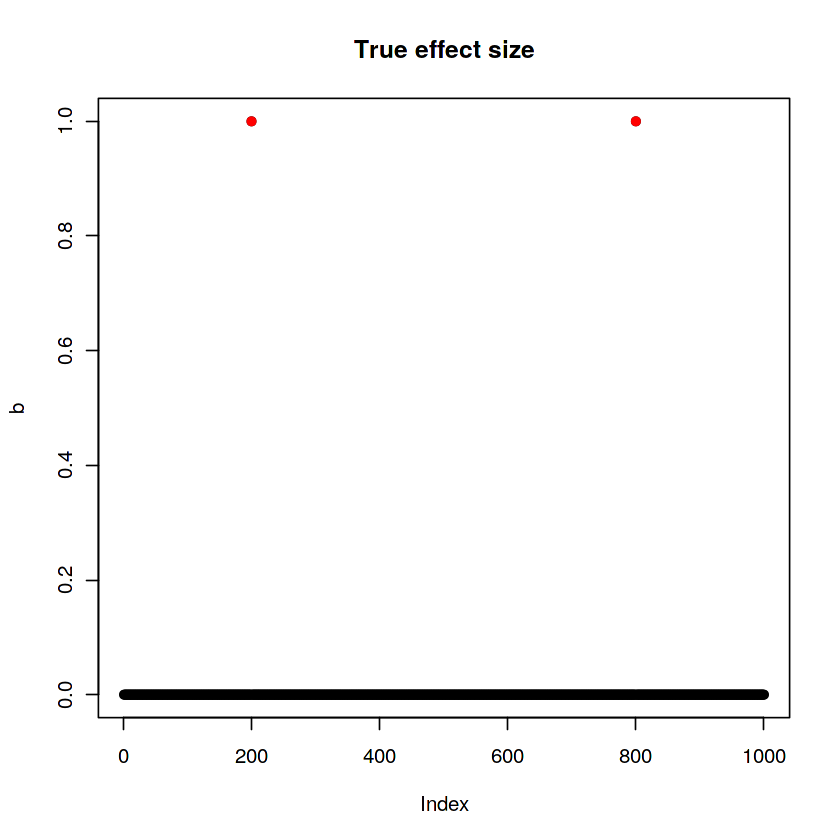

In [9]:
plot(b, col="black", pch=16, main = 'True effect size')
pos = 1:length(b)
points(pos[b!=0],b[b!=0],col=2,pch=16)

## LASSO inference

LASSO will simply choose one of:

- $x_1, x_3$
- $x_1, x_4$
- $x_2, x_3$
- $x_2, x_4$

This is not what we want. For instance on the simulated data,

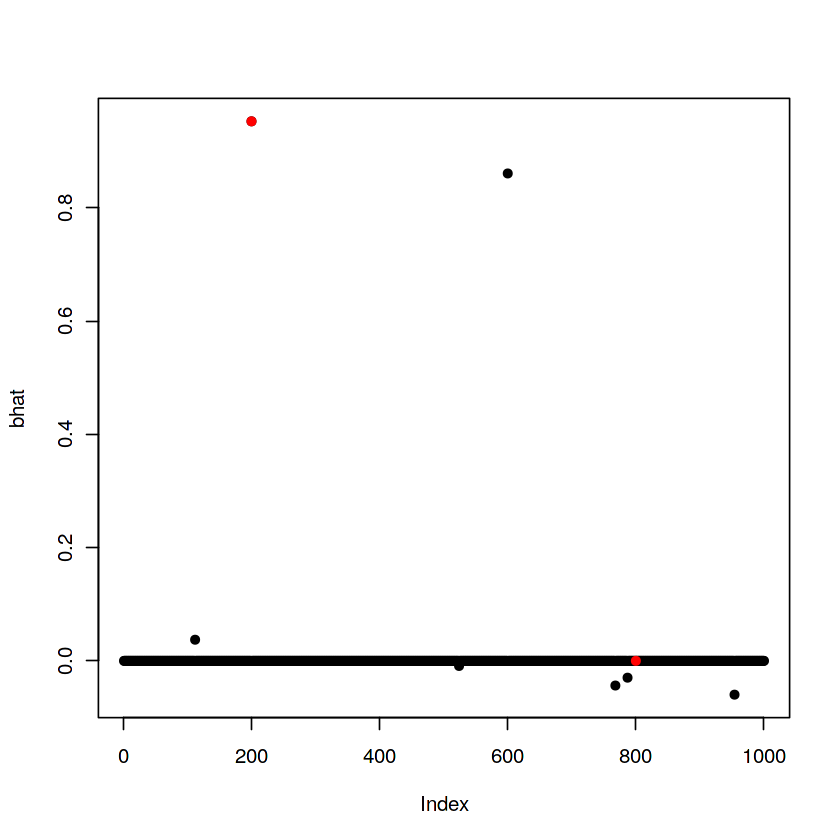

In [3]:
alpha = 1
y.fit = glmnet::glmnet(X,y,alpha = alpha,intercept = FALSE)
y.cv  = glmnet::cv.glmnet(X,y,alpha = alpha,intercept = FALSE,
                         lambda = y.fit$lambda)
bhat  = glmnet::predict.glmnet(y.fit,type ="coefficients",
                               s = y.cv$lambda.min)[-1,1]
plot(bhat, col="black", pch=16)
pos = 1:length(bhat)
points(pos[b!=0],bhat[b!=0],col=2,pch=16, main = 'Lasso')        

LASSO randomly picked $x_1$ and $x_3$ even though the true non-zero effects are $\beta_1$ and $\beta_4$.

## Existing Bayesian methods for sparse regression

For sparse enough problems, most other Bayesian methods provide posterior probabilities on "models" by enumerating (CAVIAR), schochastic search (FINEMAP) or sampling (BIMBAM) from all possible combinations of variables. In our motivating example, the "true" posterior for models are
\begin{align}
p(\beta_1 \ne 0, \beta_2 = 0, \beta_3 \ne 0, \beta_4 = 0, \beta_{5:p} = 0) &= 0.25 \\
p(\beta_1 = 0, \beta_2 \ne 0, \beta_3 \ne 0, \beta_4 = 0, \beta_{5:p} = 0) &= 0.25 \\
p(\beta_1 \ne 0, \beta_2 = 0, \beta_3 = 0, \beta_4 \ne 0, \beta_{5:p} = 0) &= 0.25 \\
p(\beta_1 = 0, \beta_2 \ne 0, \beta_3 = 0, \beta_4 \ne 0, \beta_{5:p} = 0) &= 0.25.
\end{align}
Although compared to LASSO the model posterior contains the information to make statements about $\beta_1 \ne 0 \text{ or } \beta_2 \ne 0, \text{ and } \beta_3 \ne 0 \text{ or } \beta_4 \ne 0$, it is not explicitly provided. One has to post-process these posteriors in order to make the statement. Such pre-processing is non-trivial, see eg Stephens and Balding 2009 for an example in the context of genetic fine-mapping. 

In addition, marginalized probabilities are often provided by these Bayesian methods, calcualted as
\begin{align}
p(\beta_1) &= p(\beta_1 \ne 0, \beta_2 = 0, \beta_3 \ne 0, \beta_4 = 0, \beta_{5:p} = 0) \\
& + p(\beta_1 \ne 0, \beta_2 = 0, \beta_3 = 0, \beta_4 \ne 0, \beta_{5:p} = 0)  \\
& = 0.5,
\end{align}
but this does not provide the type of inference we are interested in.

We illustrate Bayesian variable selection using `FINEMAP`,

In [4]:
library(abind)
mm_regression = function(X, Y, Z=NULL) {
  if (!is.null(Z)) {
      Z = as.matrix(Z)
  }
  reg = lapply(seq_len(ncol(Y)), function (i) simplify2array(susieR:::univariate_regression(X, Y[,i], Z)))
  reg = do.call(abind, c(reg, list(along=0)))
  # return array: out[1,,] is betahat, out[2,,] is shat
  return(aperm(reg, c(3,2,1)))
}
sumstats = mm_regression(as.matrix(X), as.matrix(y))
dat = list(X=X,Y=as.matrix(y))
saveRDS(list(data=dat, sumstats=sumstats), '/tmp/Toy.with_sumstats.rds')

In [5]:
export PATH=~/GIT/github/mvarbvs/dsc/modules/linux:$PATH
Rscript ~/GIT/software/susieR/inst/code/finemap.R input=\"/tmp/Toy.with_sumstats.rds\" output=\"N2finemapping.FINEMAP\" args=\"--n-causal-max\ 2\" 2> /dev/null


|---------------------------------|
| Welcome to FINEMAP v1.1         |
|                                 |
| (c) 2015 University of Helsinki |
|                                 |
| Help / Documentation:           |
| - ./finemap --help              |
| - www.christianbenner.com       |
|                                 |
| Contact:                        |
| - christian.benner@helsinki.fi  |
| - matti.pirinen@helsinki.fi     |
|---------------------------------|

--------
SETTINGS
--------
- regions         : 1 
- n-causal-max    : 2
- n-configs-top   : 50000
- n-iterations    : 100000
- n-convergence   : 1000
- prob-tol        : 0.001
- corr-config     : 0.95
- prior-std       : 0.05
- prior-k0        : 0

---------------
RUNNING FINEMAP (1/1)
---------------
- GWAS z-scores                   : /tmp/RtmpRoiPgb/file251112eb567f.finemap_condition_1.z
- SNP correlations                : /tmp/RtmpRoiPgb/file25116d0f14ab.ld
- Causal SNP configurations       : /tmp/RtmpRoiPgb/file251112eb

Posterior probabilities for "models" are:

In [6]:
finemap = readRDS("N2finemapping.FINEMAP.rds")[[1]]
head(finemap$set)

rank,config,config_prob,config_log10bf
1,"200,800",0.25,65.64032
2,"200,600",0.25,65.64032
3,"400,800",0.25,65.64032
4,"400,600",0.25,65.64032
5,200,0.00,41.57626
6,400,0.00,41.57626


`FINEMAP` correctly determined 4 "model configurations" as expected, each with probability 0.25. Simply marginalizing across all models we obtain posterior inclusion probability per feature,

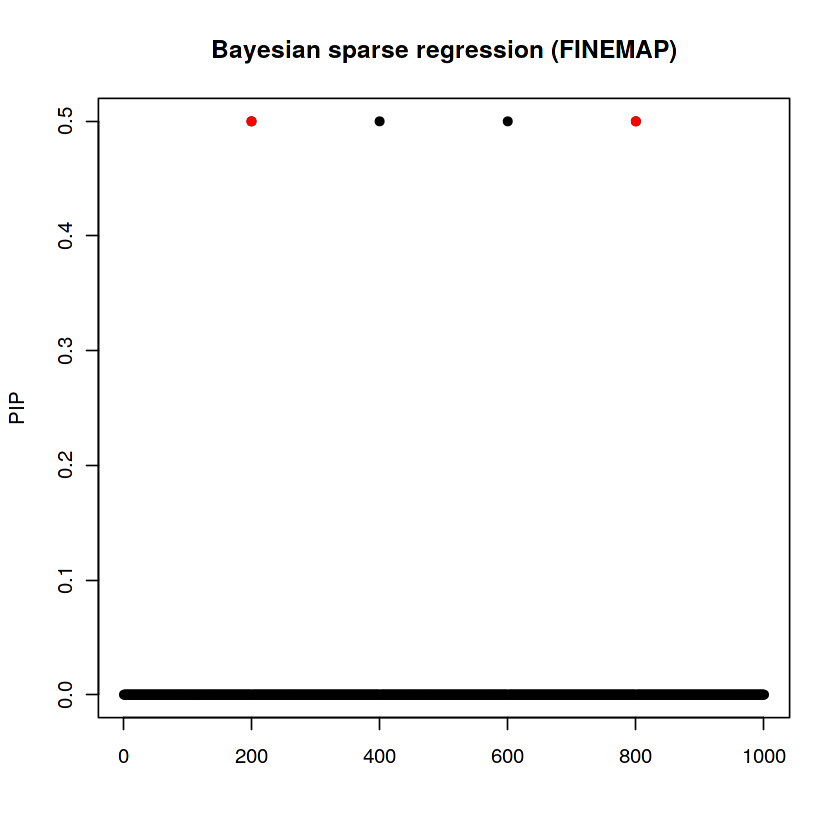

In [7]:
snp = finemap$snp
pip = snp[order(as.numeric(snp$snp)),]$snp_prob
susieR::susie_pplot(pip, dtype='PIP', b=b, main = 'Bayesian sparse regression (FINEMAP)')

From these marginalized posterior we can only make a statement that each of the 4 identified variables have 0.5 probability of being non-zero. That is, they all have equal contributions. It does not reflect the fact that the result comes from identical feature pairs $x_1, x_2$ and $x_3, x_4$.

Existing variational inference methods (`varbvs`) do not provide accurate calculation of marginal posterior probabilities, although like LASSO, existing variational methods are good for prediction purposes.

## SuSiE

SuSiE uses a variational inference algorithm which is not only computational convenient, but also directly obtains posterior statements of the desired form.

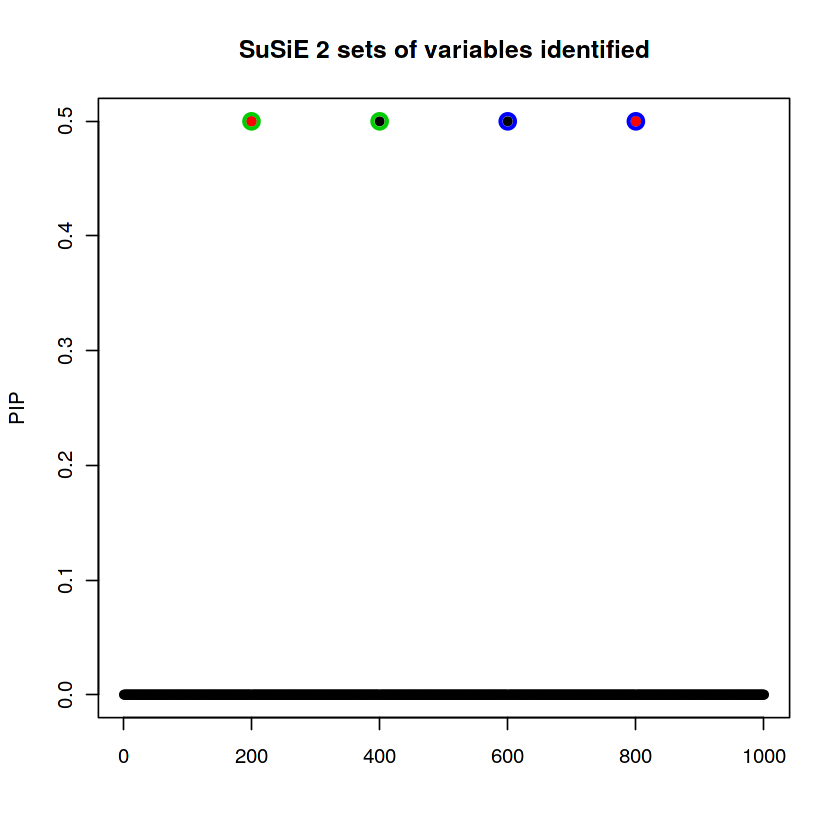

In [8]:
fitted = susieR::susie(X, y, L=5,
               estimate_residual_variance=TRUE, 
               scaled_prior_variance=0.2,
               tol=1e-3, track_fit=TRUE)
sets = susieR::susie_get_CS(fitted,
            coverage = 0.95,
            X = X, 
            min_abs_corr = 0.1)
pip = susieR::susie_get_PIP(fitted, sets$cs_index)
susieR::susie_pplot(pip, res=fitted, CS=sets, dtype='PIP', b=b, max_cs=0.4, main = paste('SuSiE', length(sets$cs), 'sets of variables identified'))

Here SuSiE identifies 2 sets of variables -- 2 confidence sets each containing one causal variable (blue and green circles). The marginal posterior is the same as from existing Bayesian methods (FINEMAP result), but with the two sets identified one can easily state that the causal variables are ($x_1$ or $x_2$), and ($x_3$ or $x_4$). Within each set, the contributions of variables are equal because there is no information to distinguish between them.

Notice that SuSiE does not directly provide posterior of model configuration, that is, inference on ($x_1$ and $x_3$), or ($x_1$ and $x_4$), or ($x_2$ and $x_3$), or ($x_2$ and $x_4$).